# Siamese neural networks for omniglot dataset

## Omniglot dataset
- 1623 hand drawn characters
- 50 alphabets
- 20 examples for each character
- image resolution 105 x 105

Training Data
- 964 characters
- 19,280 images

Validation Data
- 659 characters
- 13,180 images

### Preprocessing
- Pickle the omniglot data for cleaner structure and easier data loading

Import packages

In [1]:
# general packages
import numpy as np
from imageio import imread
import pickle
import os
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Keras packages
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Define paths

In [2]:
# data_path = 'C:/Users/hydro/Desktop/AI/omniglot' 
data_path = '/home/ubuntu/omniglot/python'
train_path = os.path.join(data_path,'images_background') # 30 alphabets
val_path = os.path.join(data_path,'images_evaluation')  # 20 alphabets
weights_path = os.path.join(data_path, "weights")

Define load function to 
- load data in an array: (characters, images, width , height)
- store index into a dictionary: {language: [start_index, end_index]}


In [15]:
def load_omniglot(path):

    image_array = [] # store image data etc in an array. Eg. (characters, images, width , height)
    language_dict = {} # store language and its index. Eg. {'Alphabet_of_the_Magi': [0, 19]}
    count = 0
    
    # For each language (eg. 'Balinese' ...)
    for language in os.listdir(path): 
        
        language_dict[language] = [count, None]
        language_path = os.path.join(path, language)
        
        # For each character within the language folder (eg. letter = 'character01' , 'character02'...)
        for character in os.listdir(language_path): 
            character_path = os.path.join(language_path, character)
            
            # empty list to store all the images of the particular character
            image_list = []
            
            # For each individual image of the character (eg. 0299_01, 0299_02)
            for image in os.listdir(character_path):
                image_path = os.path.join(character_path, image)
                
                # image to numpy array
                image = imread(image_path) 
                
                # store image in the list
                image_list.append(image)
                
            image_array.append(np.stack(image_list))

            language_dict[language][1] = count
            
            count += 1

    image_array = np.stack(image_array) 
    
    return image_array, language_dict


Pickle the arrays and dictionaries

In [4]:
train_array, train_language_dict = load_omniglot(train_path)
with open(os.path.join(data_path,"train.pickle"), "wb") as f:
	pickle.dump((train_array,train_language_dict),f)


val_array, val_language_dict = load_omniglot(val_path)
with open(os.path.join(data_path,"val.pickle"), "wb") as f:
	pickle.dump((val_array,val_language_dict),f)

Print out the array shapes and dictionaries to double check

In [6]:
print('\nTraining array shape = ', train_array.shape)
print('\nTraining language dictionary = ', train_language_dict)
    
print('\nValidation array shape = ', val_array.shape)
print('\nValidation language dictionary = ', val_language_dict)    


Training array shape =  (964, 20, 105, 105)

Training language dictionary =  {'Alphabet_of_the_Magi': [0, 19], 'Anglo-Saxon_Futhorc': [20, 48], 'Arcadian': [49, 74], 'Armenian': [75, 115], 'Asomtavruli_(Georgian)': [116, 155], 'Balinese': [156, 179], 'Bengali': [180, 225], 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [226, 239], 'Braille': [240, 265], 'Burmese_(Myanmar)': [266, 299], 'Cyrillic': [300, 332], 'Early_Aramaic': [333, 354], 'Futurama': [355, 380], 'Grantha': [381, 423], 'Greek': [424, 447], 'Gujarati': [448, 495], 'Hebrew': [496, 517], 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [518, 533], 'Japanese_(hiragana)': [534, 585], 'Japanese_(katakana)': [586, 632], 'Korean': [633, 672], 'Latin': [673, 698], 'Malay_(Jawi_-_Arabic)': [699, 738], 'Mkhedruli_(Georgian)': [739, 779], 'N_Ko': [780, 812], 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [813, 826], 'Sanskrit': [827, 868], 'Syriac_(Estrangelo)': [869, 891], 'Tagalog': [892, 908], 'Tifinagh': [909, 963]}

Validation array shap

## The algorithm
- The original Lake et al. paper used Hierachical Bayesian Program Learning (GBPL)
- HBPL data used stokes, which requires more complicated annotation and is hard to be generalizable
- Siamese neural networks are chosen for this challenge because:
<br> (1) it is well suited for one-shot-learning problem; and  
(2) it can be generalized to other challenges beyond Omniglot
    

### Siamese neural networks
- Siamese neural networks for one-shot image recognition was proposed in [Koch et al. paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
- The networks are good for diffentiating two images. 
- Its architecture consists of two identical neural nets that share the same weights. 
- Each image in an image pair is feeded into one of the two neural nets and the differences between the two vectors are used as inputs for a logistic regression classifier
- The loss function used for logistic regression is binary cross entropy.
- L2 regularization is used to prevent over-fitting

<img src="siamese.png">



### Weights and biases are initialized according to [Koch et al. paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

#### Weight initialization
- convolutional layers & fully connected layer: 
<br> (1) normal distribution
<br> (2) mean = 0
<br> (3) standard deviation = 10^-2

#### Bias initialization
- convolutional layers & fully connected layer:
<br> (1) normal distribution
<br> (2) mean = 0.5
<br> (3) standard deviation = 10^2. 


In [3]:
def weight_initializer(shape, name=None):
    values = np.random.normal(loc=0, scale=1e-2, size=shape)
    return K.variable(values, name=name)

def bias_initializer(shape, name=None):
    values = np.random.normal(loc=0.5, scale=1e-2, size=shape)
    return K.variable(values ,name=name)

# Omniglot data input shape
input_shape = (105, 105, 1)

### Convolutional Neural Networks

Define the structure for CNN used
<img src='cnn.png'>

In [4]:
# Convolutional Neural Networks
convnet = Sequential()

# First convolutional layer
convnet.add(Conv2D(64,(10,10),
           activation='relu',
           input_shape=input_shape,
           kernel_initializer=weight_initializer,
           kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())

# Second convolutional layer
convnet.add(Conv2D(128,(7,7),
           activation='relu',
           kernel_regularizer=l2(2e-4),
           kernel_initializer=weight_initializer,
           bias_initializer=bias_initializer))
convnet.add(MaxPooling2D())

# Third convolutional layer
convnet.add(Conv2D(128,(4,4),
           activation='relu',
           kernel_initializer=weight_initializer,
           kernel_regularizer=l2(2e-4),
           bias_initializer=bias_initializer))
convnet.add(MaxPooling2D())

# Fourth convolutional layer
convnet.add(Conv2D(256,(4,4),
           activation='relu',
           kernel_initializer=weight_initializer,
           kernel_regularizer=l2(2e-4),
           bias_initializer=bias_initializer))
convnet.add(Flatten())

# Fully connected layer
convnet.add(Dense(4096,
          activation="sigmoid",
          kernel_regularizer=l2(1e-3),
          kernel_initializer=weight_initializer,
          bias_initializer=bias_initializer))

- Assign two images in a pair as left or right inputs and convert to tensors
- L1 component-wise distance between two vectors are calculated after the fully connected layer
- Optimization: Adam Optimizer

In [5]:
# convert input images into tensors
left_input = Input(input_shape)
right_input = Input(input_shape)

# call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

# call this layer on list of two input tensors.
prediction = Dense(1,activation='sigmoid',bias_initializer=bias_initializer)(L1_distance)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

siamese_net.compile(loss = "binary_crossentropy", optimizer = Adam(0.00006))


### Training configuration

In [6]:
#Training loop
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 10 # interval for printing loss (iterations)
batch_size = 32 # how many pair of images for each batch
n_iter =  10000 
N_character = 20 # how many languages for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

### Define Siamese neural network class

In [7]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, train_val = ["train", "val"]):
        self.data = {}
        self.language = {}
        self.info = {}
        
        # load training and validation array              --->   self.data dictionary
        # load training and validation index dictionaries --->   self.categories dictionary 
        
        for t_v in train_val:
            file_path = os.path.join(path, t_v + ".pickle")

            with open(file_path,"rb") as f:
                (data_array,language_dict) = pickle.load(f)
                self.data[t_v] = data_array
                self.language[t_v] = language_dict

    def get_batch(self,batch_size, train_val = "train"):
        """Create batch of n pairs, half same class, half different class"""
        
        # load training or validation data into data array dictionary 
        data_array = self.data[train_val]
        
        # Extract the training dataset parameters
        n_character, n_example, weight, height = data_array.shape

        # randomly sample several characters to use in the batch
        random_character_batch = np.random.choice(n_character,size=(batch_size,),replace=False)
        
        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, height, weight, 1)) for i in range(2)]
        
        # initialize vector for the targets
        # make one half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        
        for i in range(batch_size):
            # choose one character
            one_character = random_character_batch[i]
            
            # First image in the pair 
            # Generate a random list of integers
            idx_1 = np.random.randint(0, n_example)
             
            # First image in the pair
            # Array data of a randomly selected image is loaded onto pairs[0]
            pairs[0][i,:,:,:] = data_array[one_character, idx_1].reshape(weight, height, 1)
            
            # pick images of same language for 1st half, different for 2nd
            if i >= batch_size // 2:
                character_2 = one_character 
                
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                character_2 = (one_character + np.random.randint(1, n_character)) % n_character
                
                
            idx_2 = np.random.randint(0, n_example)
            
            pairs[1][i,:,:,:] = data_array[character_2,idx_2].reshape(weight, height, 1)
            
        return pairs, targets
    
    def generate(self, batch_size, train_val = "train"):
        """a generator for batches, so model.fit_generator can be used. """
        
        while True:
            pairs, targets = self.get_batch(batch_size, train_val)
            yield (pairs, targets)    

    def make_oneshot_task(self, N_character, train_val = "val", language = None):
        """Create pairs of test image, support set for testing N character one-shot learning. """
        
        # load validation data into data array dictionary 
        data_array = self.data[train_val]
        
        # Extract the validation dataset parameters
        n_character, n_example, weight, height = data_array.shape
        
        # generate random indices
        indices = np.random.randint(0, n_example, size=(N_character,))
        
        # if a language is specified, use only character from that language
        if language is not None:
            # get the highest and lowest indexes of that particulra language
            low_index, high_index = self.language[train_val][language]
            
            # if the total characters in the language is less than specified, print error
            if N_character > high_index - low_index:
                raise ValueError("This language ({}) has less than {} characters".format(language, N_character))
                
            random_character = np.random.choice(range(low_index, high_index),size=(N_character,),replace=False)
        
        # if no language specified just pick a bunch of random letters
        else:
            
            random_character = np.random.choice(range(n_character),size=(N_character,),replace=False) 
            
        true_category = random_character[0]
        ex1, ex2 = np.random.choice(n_example, replace=False, size=(2,))
        test_image = np.asarray([data_array[true_category,ex1,:,:]] * N_character).reshape(N_character, weight, height, 1)
        
        # support set is a set of one image from each characters
        # to be compared with the target image
        support_set = data_array[random_character, indices,:,:]
        support_set[0,:,:] = data_array[true_category, ex2]
        support_set = support_set.reshape(N_character, weight, height, 1)
        
        # targets = the test image
        targets = np.zeros((N_character,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model, N_character, n_val, train_val ="val"):
        """Test average N way oneshot learning accuracy of a siamese neural net over n one-shot tasks"""
        
        n_correct = 0
        
        for i in range(n_val):
            inputs, targets = self.make_oneshot_task(N_character,train_val)
            probs = model.predict(inputs)
            
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
                
        percent_correct = (100.0*n_correct / n_val)
        
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),)
    
    
#Instantiate the class
loader = Siamese_Loader(data_path)

### Training
- Using a batch size of 32
- evalute loss and accuracy for every 10 iteration
- Accuracy = Randomly selected 250 images from any language


In [9]:
print("Training...")

loss_list, accuracy_list = [], []

for i in range(1, n_iter):
  
    (inputs,targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net, N_character, n_val)
        
        loss_list.append(loss)
        accuracy_list.append(val_acc)
        
        if val_acc >= best:
            siamese_net.save(weights_path)
            best = val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f}, accuracy: {}".format(i, loss, val_acc))

Training...
iteration 10, training loss: 3.06, accuracy: 19.2
iteration 20, training loss: 3.04, accuracy: 26.8
iteration 30, training loss: 3.01, accuracy: 29.6
iteration 40, training loss: 2.89, accuracy: 16.8
iteration 50, training loss: 2.84, accuracy: 28.4
iteration 60, training loss: 2.86, accuracy: 27.2
iteration 70, training loss: 2.61, accuracy: 31.2
iteration 80, training loss: 2.71, accuracy: 25.2
iteration 90, training loss: 2.52, accuracy: 20.4
iteration 100, training loss: 2.60, accuracy: 28.8
iteration 110, training loss: 2.52, accuracy: 34.4
iteration 120, training loss: 2.41, accuracy: 26.4
iteration 130, training loss: 2.40, accuracy: 30.4
iteration 140, training loss: 2.43, accuracy: 32.0
iteration 150, training loss: 2.45, accuracy: 32.8
iteration 160, training loss: 2.12, accuracy: 26.0
iteration 170, training loss: 2.06, accuracy: 33.6
iteration 180, training loss: 2.18, accuracy: 30.8
iteration 190, training loss: 2.18, accuracy: 28.0
iteration 200, training loss

iteration 1610, training loss: 0.78, accuracy: 69.6
iteration 1620, training loss: 0.83, accuracy: 68.0
iteration 1630, training loss: 0.73, accuracy: 70.4
iteration 1640, training loss: 0.77, accuracy: 64.4
iteration 1650, training loss: 0.72, accuracy: 66.4
iteration 1660, training loss: 0.62, accuracy: 52.8
iteration 1670, training loss: 0.74, accuracy: 62.0
iteration 1680, training loss: 0.70, accuracy: 66.0
iteration 1690, training loss: 0.77, accuracy: 57.6
iteration 1700, training loss: 0.82, accuracy: 62.8
iteration 1710, training loss: 1.00, accuracy: 58.0
iteration 1720, training loss: 0.63, accuracy: 68.8
iteration 1730, training loss: 0.60, accuracy: 63.6
iteration 1740, training loss: 0.81, accuracy: 64.8
iteration 1750, training loss: 0.59, accuracy: 66.4
iteration 1760, training loss: 0.65, accuracy: 68.0
iteration 1770, training loss: 0.60, accuracy: 64.0
iteration 1780, training loss: 0.83, accuracy: 66.8
iteration 1790, training loss: 0.88, accuracy: 66.0
iteration 18

iteration 3190, training loss: 0.62, accuracy: 72.4
iteration 3200, training loss: 0.38, accuracy: 70.0
iteration 3210, training loss: 0.46, accuracy: 64.4
iteration 3220, training loss: 0.34, accuracy: 67.6
iteration 3230, training loss: 0.38, accuracy: 76.8
iteration 3240, training loss: 0.40, accuracy: 68.4
iteration 3250, training loss: 0.51, accuracy: 69.6
iteration 3260, training loss: 0.43, accuracy: 65.6
iteration 3270, training loss: 0.37, accuracy: 75.2
iteration 3280, training loss: 0.36, accuracy: 62.0
iteration 3290, training loss: 0.38, accuracy: 66.8
iteration 3300, training loss: 0.36, accuracy: 69.6
iteration 3310, training loss: 0.55, accuracy: 64.4
iteration 3320, training loss: 0.37, accuracy: 71.6
iteration 3330, training loss: 0.62, accuracy: 69.6
iteration 3340, training loss: 0.54, accuracy: 73.2
iteration 3350, training loss: 0.44, accuracy: 74.4
iteration 3360, training loss: 0.38, accuracy: 69.6
iteration 3370, training loss: 0.43, accuracy: 70.8
iteration 33

iteration 4770, training loss: 0.31, accuracy: 69.2
iteration 4780, training loss: 0.30, accuracy: 78.8
iteration 4790, training loss: 0.39, accuracy: 76.4
iteration 4800, training loss: 0.40, accuracy: 72.8
iteration 4810, training loss: 0.38, accuracy: 71.6
iteration 4820, training loss: 0.31, accuracy: 71.6
iteration 4830, training loss: 0.28, accuracy: 77.6
iteration 4840, training loss: 0.32, accuracy: 76.0
iteration 4850, training loss: 0.27, accuracy: 71.2
iteration 4860, training loss: 0.28, accuracy: 75.6
iteration 4870, training loss: 0.26, accuracy: 75.6
iteration 4880, training loss: 0.25, accuracy: 68.8
iteration 4890, training loss: 0.33, accuracy: 74.0
iteration 4900, training loss: 0.27, accuracy: 80.8
iteration 4910, training loss: 0.34, accuracy: 79.6
iteration 4920, training loss: 0.29, accuracy: 77.2
iteration 4930, training loss: 0.32, accuracy: 75.6
iteration 4940, training loss: 0.47, accuracy: 75.2
iteration 4950, training loss: 0.51, accuracy: 70.0
iteration 49

iteration 6350, training loss: 0.24, accuracy: 77.6
iteration 6360, training loss: 0.25, accuracy: 76.8
iteration 6370, training loss: 0.29, accuracy: 75.6
iteration 6380, training loss: 0.26, accuracy: 74.4
iteration 6390, training loss: 0.23, accuracy: 74.4
iteration 6400, training loss: 0.21, accuracy: 77.2
iteration 6410, training loss: 0.30, accuracy: 75.2
iteration 6420, training loss: 0.25, accuracy: 78.8
iteration 6430, training loss: 0.22, accuracy: 70.4
iteration 6440, training loss: 0.30, accuracy: 71.6
iteration 6450, training loss: 0.29, accuracy: 76.4
iteration 6460, training loss: 0.35, accuracy: 76.8
iteration 6470, training loss: 0.29, accuracy: 72.4
iteration 6480, training loss: 0.31, accuracy: 70.0
iteration 6490, training loss: 0.27, accuracy: 68.4
iteration 6500, training loss: 0.45, accuracy: 77.6
iteration 6510, training loss: 0.44, accuracy: 76.0
iteration 6520, training loss: 0.26, accuracy: 75.2
iteration 6530, training loss: 0.28, accuracy: 77.6
iteration 65

iteration 7930, training loss: 0.44, accuracy: 74.8
iteration 7940, training loss: 0.21, accuracy: 78.4
iteration 7950, training loss: 0.26, accuracy: 79.6
iteration 7960, training loss: 0.23, accuracy: 78.4
iteration 7970, training loss: 0.20, accuracy: 78.0
iteration 7980, training loss: 0.22, accuracy: 75.6
iteration 7990, training loss: 0.31, accuracy: 78.4
iteration 8000, training loss: 0.25, accuracy: 82.4
iteration 8010, training loss: 0.26, accuracy: 79.6
iteration 8020, training loss: 0.21, accuracy: 78.0
iteration 8030, training loss: 0.38, accuracy: 79.6
iteration 8040, training loss: 0.33, accuracy: 73.2
iteration 8050, training loss: 0.25, accuracy: 70.0
iteration 8060, training loss: 0.25, accuracy: 78.0
iteration 8070, training loss: 0.30, accuracy: 76.4
iteration 8080, training loss: 0.27, accuracy: 75.2
iteration 8090, training loss: 0.30, accuracy: 74.4
iteration 8100, training loss: 0.40, accuracy: 74.0
iteration 8110, training loss: 0.22, accuracy: 75.2
iteration 81

iteration 9510, training loss: 0.20, accuracy: 79.2
iteration 9520, training loss: 0.17, accuracy: 81.6
iteration 9530, training loss: 0.23, accuracy: 76.8
iteration 9540, training loss: 0.22, accuracy: 74.0
iteration 9550, training loss: 0.45, accuracy: 76.8
iteration 9560, training loss: 0.34, accuracy: 79.6
iteration 9570, training loss: 0.26, accuracy: 75.6
iteration 9580, training loss: 0.32, accuracy: 73.2
iteration 9590, training loss: 0.25, accuracy: 75.2
iteration 9600, training loss: 0.23, accuracy: 81.6
iteration 9610, training loss: 0.20, accuracy: 73.2
iteration 9620, training loss: 0.20, accuracy: 75.2
iteration 9630, training loss: 0.27, accuracy: 77.2
iteration 9640, training loss: 0.22, accuracy: 80.0
iteration 9650, training loss: 0.19, accuracy: 76.0
iteration 9660, training loss: 0.22, accuracy: 75.6
iteration 9670, training loss: 0.33, accuracy: 80.0
iteration 9680, training loss: 0.24, accuracy: 81.6
iteration 9690, training loss: 0.20, accuracy: 75.6
iteration 97

### Plot accuracy

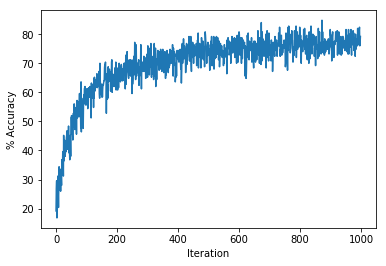

In [18]:
# Plot accuracy

plt.plot(accuracy_list)
plt.xlabel("Iteration")
plt.ylabel("% Accuracy")
plt.savefig('accuracy.png')



In [17]:
print('Average accurarcy for 10 x 250 test images = {0:.2f} %'.format(sum(accuracy_list[-10:])/10))

Average accurarcy for 10 x 250 test images = 79.20 %
